In [ ]:
import kagglehub
from PIL import Image
import io
import random
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import AutoImageProcessor, SwinForImageClassification
from transformers import ViTImageProcessor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import os
import csv
import time

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Fixar o seed para reprodutividade
set_seed()

In [ ]:
# Download latest version
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

print("Path to dataset files:", path)

# Caminho para o dataset
train_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'

# Carrega o parquet
df = pd.read_parquet(train_path)

Path to dataset files: /kaggle/input/alzheimer-mri-disease-classification-dataset


In [ ]:
# Label map
label_map = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

In [ ]:
# Dataset customizado
class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_bytes = self.df.iloc[idx]['image']['bytes']
        label = self.df.iloc[idx]['label']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
model_name = "microsoft/swin-tiny-patch4-window7-224"

# Carrega o processador e o modelo Swin
processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized 

In [ ]:
# Transforms com o feature_extractor
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=processor.image_mean,
        std=processor.image_std
    )
])

In [ ]:
# Criação do dataset e dataloader
dataset = AlzheimerDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Época 1/10: 100%|██████████| 320/320 [01:20<00:00,  3.96it/s]


Loss da época 1: 1.2082


Época 2/10: 100%|██████████| 320/320 [01:18<00:00,  4.07it/s]


Loss da época 2: 1.0389


Época 3/10: 100%|██████████| 320/320 [01:13<00:00,  4.33it/s]


Loss da época 3: 0.7750


Época 4/10: 100%|██████████| 320/320 [01:13<00:00,  4.34it/s]


Loss da época 4: 0.5241


Época 5/10: 100%|██████████| 320/320 [01:13<00:00,  4.34it/s]


Loss da época 5: 0.3017


Época 6/10: 100%|██████████| 320/320 [01:14<00:00,  4.32it/s]


Loss da época 6: 0.1781


Época 7/10: 100%|██████████| 320/320 [01:13<00:00,  4.34it/s]


Loss da época 7: 0.1125


Época 8/10: 100%|██████████| 320/320 [01:13<00:00,  4.34it/s]


Loss da época 8: 0.1310


Época 9/10: 100%|██████████| 320/320 [01:14<00:00,  4.32it/s]


Loss da época 9: 0.0630


Época 10/10: 100%|██████████| 320/320 [01:14<00:00,  4.32it/s]

Loss da época 10: 0.0289


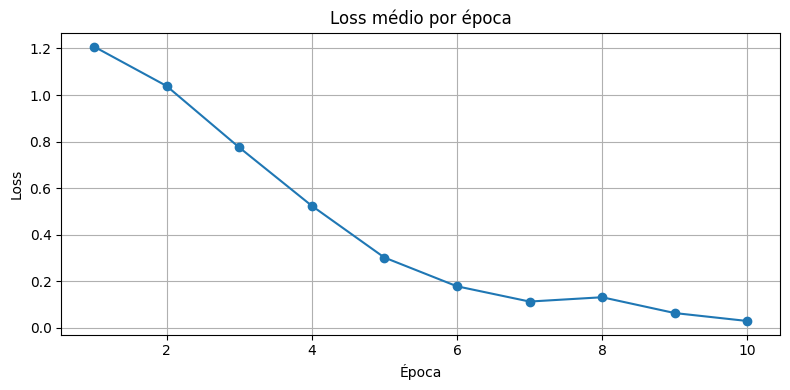

CPU times: user 13min 34s, sys: 11.9 s, total: 13min 46s
Wall time: 12min 30s


In [ ]:
%%time
# Número de exemplos por classe, na ordem dos rótulos
class_counts = torch.tensor([172, 15, 634, 459], dtype=torch.float32)

# Frequência relativa (dividido pelo total)
total = class_counts.sum()
freqs = class_counts / total

# Peso = inverso da frequência
weights = 1.0 / freqs

# Normaliza para evitar explosão de gradientes
weights = weights / weights.sum()

# Enviar para GPU
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm

# Inicializa histórico
epoch_losses = []
num_epochs = 10

star_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Loop por batch
    for images, labels in tqdm(dataloader, desc=f"Época {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Média da época
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Loss da época {epoch+1}: {epoch_loss:.4f}")

end_time = time.time()
tempo_total = end_time - star_time # segundos

# Grafico por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.title("Loss médio por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Caminho para o arquivo de teste
test_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'

# Lê o Parquet
df_test = pd.read_parquet(test_path)

# Cria o dataset e o dataloader de teste
test_dataset = AlzheimerDataset(df_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Coloque o modelo em modo de avaliação
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in tqdm(test_dataloader, desc="Avaliando"):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.logits, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

Avaliando: 100%|██████████| 80/80 [00:07<00:00, 10.68it/s]


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

modelo = "Swin-tiny-patch4-window7-224"

# Relatório completo por classe
print(f"\nModelo {modelo}")
print("\nRelatório por classe:")
print(classification_report(y_true, y_pred, target_names=[label_map[i] for i in range(4)], zero_division=0))

Acurácia: 0.9016
Precisão: 0.9114
Revocação: 0.9016
F1-score: 0.8997

Modelo Swin-tiny-patch4-window7-224

Relatório por classe:
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.77      0.87       172
 Moderate_Demented       1.00      0.93      0.97        15
      Non_Demented       0.85      1.00      0.92       634
Very_Mild_Demented       0.95      0.82      0.88       459

          accuracy                           0.90      1280
         macro avg       0.95      0.88      0.91      1280
      weighted avg       0.91      0.90      0.90      1280



In [ ]:
# Calcula a matriz
cm = confusion_matrix(y_true, y_pred)

# Converte para DataFrame com rótulos
cm_df = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())

print("Matriz de confusão:\n")
print(cm_df.to_string())

Matriz de confusão:

                    Mild_Demented  Moderate_Demented  Non_Demented  Very_Mild_Demented
Mild_Demented                 132                  0            24                  16
Moderate_Demented               0                 14             0                   1
Non_Demented                    0                  0           633                   1
Very_Mild_Demented              0                  0            84                 375


In [ ]:
resultados = {
    "modelo": modelo,
    "epocas": num_epochs,
    "tempo_total": round(tempo_total, 2), # em segundos
    "acuracia": round(accuracy, 4),
    "precisao": round(precision, 4),
    "revocacao": round(recall, 4),
    "f1_macro": round(f1, 4)
}

In [ ]:
import re

def limpar_nome_arquivo(nome):
    """
    Substitui caracteres inválidos em nomes de arquivos por underline (_).

    Parâmetros:
    nome (str): O nome original do arquivo que pode conter caracteres inválidos.

    Retorna:
    str: Uma versão do nome do arquivo onde os caracteres inválidos (\, /, :, ", *, ?, <, >, |)
         foram substituídos por underscores (_), tornando o nome seguro para uso em sistemas de arquivos.
    """
    return re.sub(r'[\\/:"*?<>|]+', "_", nome)

nome_seguro = limpar_nome_arquivo(modelo)

In [ ]:
file_path = f"resultados_do_modelo_{nome_seguro}.csv"
campos = list(resultados.keys())

# Cria o arquivo se não existir
if not os.path.exists(file_path):
    with open(file_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writeheader()
        writer.writerow(resultados)
else:
    # Apenas adiciona nova linha
    with open(file_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writerow(resultados)